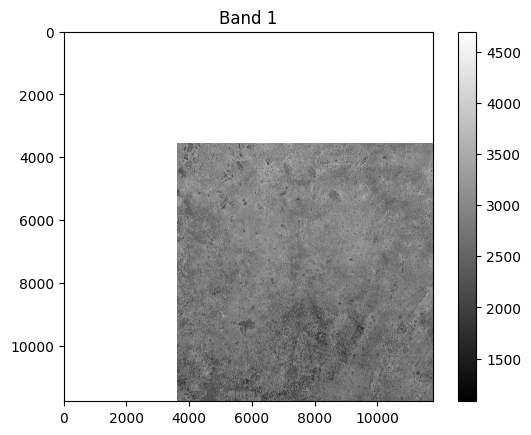

In [1]:
import rasterio
import matplotlib.pyplot as plt

# Pfad zur Ihrer TIFF-Datei
tif_file = 'Nigeria_2018/Nigeria_Sentinel2_Composite-0000000000-0000000000.tif'

# Öffnen der TIFF-Datei
with rasterio.open(tif_file) as src:
    # Lesen des ersten Bandes
    band1 = src.read(1)
    
    # Visualisieren des Bandes mit Matplotlib
    plt.imshow(band1, cmap='gray')
    plt.title('Band 1')
    plt.colorbar()
    plt.show()


In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Load the shapefile
admin_shapes = gpd.read_file('shapefiles/nga_admbnda_adm1_osgof_20190417.shp')

# Load the satellite imagery
sat_image = rasterio.open('Nigeria_2018/Nigeria_2018_Combined.tif')


In [3]:
print(admin_shapes.columns)

Index(['Shape_Leng', 'Shape_Area', 'ADM1_EN', 'ADM1_PCODE', 'ADM1_REF',
       'ADM1ALT1EN', 'ADM1ALT2EN', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn',
       'validTo', 'geometry'],
      dtype='object')


In [4]:
print(admin_shapes['ADM1_EN'])

0                          Abia
1                       Adamawa
2                     Akwa Ibom
3                       Anambra
4                        Bauchi
5                       Bayelsa
6                         Benue
7                         Borno
8                   Cross River
9                         Delta
10                       Ebonyi
11                          Edo
12                        Ekiti
13                        Enugu
14    Federal Capital Territory
15                        Gombe
16                          Imo
17                       Jigawa
18                       Kaduna
19                         Kano
20                      Katsina
21                        Kebbi
22                         Kogi
23                        Kwara
24                        Lagos
25                     Nasarawa
26                        Niger
27                         Ogun
28                         Ondo
29                         Osun
30                          Oyo
31      

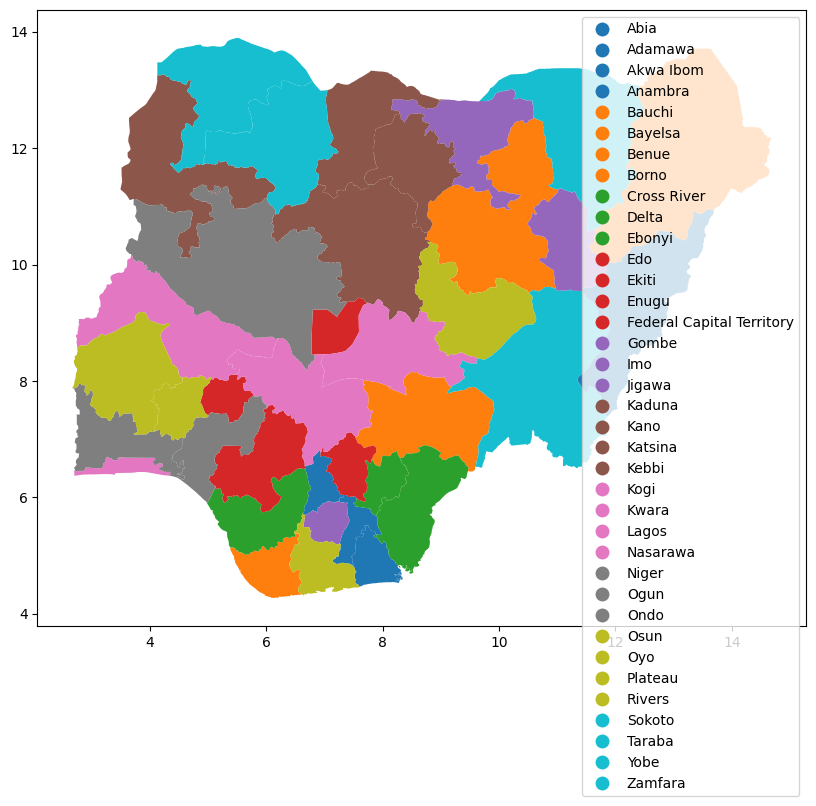

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Angenommen, `admin_shapes` ist dein GeoDataFrame mit den Regionen und Geometrien
# Achte darauf, dass die Spalte 'admin1Name' vorhanden ist und die Regionsnamen enthält

# Erstellen Sie ein neues DataFrame für die Geometrien jeder Region
regions_shapes = gpd.GeoDataFrame(columns=['geometry', 'Region'])

# Zuweisen jeder Region und deren Geometrie ins neue DataFrame
for _, row in admin_shapes.iterrows():
    temp_gdf = gpd.GeoDataFrame({'geometry': [row['geometry']], 'Region': [row['ADM1_EN']]})
    regions_shapes = pd.concat([regions_shapes, temp_gdf], ignore_index=True)

# Visualisieren der Geometrien
fig, ax = plt.subplots(figsize=(12, 8))
regions_shapes.plot(ax=ax, column='Region', legend=True)
plt.show()


In [6]:
import random
from shapely.geometry import Point

def sample_unique_coordinates(geometry, num_samples):
    minx, miny, maxx, maxy = geometry.bounds
    coordinates = set()
    
    while len(coordinates) < num_samples:
        # Erzeugen Sie einen zufälligen Punkt
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        # Überprüfen Sie, ob der Punkt innerhalb der Geometrie und nicht bereits im Set enthalten ist
        if geometry.contains(pnt) and pnt not in coordinates:
            coordinates.add(pnt)
    
    return list(coordinates)

random.seed(42)  # Setzen eines Seeds für Reproduzierbarkeit
sampled_coordinates_per_region = {}

for index, row in admin_shapes.iterrows():
    geometry = row['geometry']
    region_name = row['ADM1_EN']  # oder admin1_EN je nach tatsächlicher Spaltenbezeichnung
    sampled_coords = sample_unique_coordinates(geometry, 20)
    sampled_coordinates_per_region[region_name] = sampled_coords

In [7]:
sampled_coordinates_per_region.keys()

dict_keys(['Abia', 'Adamawa', 'Akwa Ibom', 'Anambra', 'Bauchi', 'Bayelsa', 'Benue', 'Borno', 'Cross River', 'Delta', 'Ebonyi', 'Edo', 'Ekiti', 'Enugu', 'Federal Capital Territory', 'Gombe', 'Imo', 'Jigawa', 'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Kogi', 'Kwara', 'Lagos', 'Nasarawa', 'Niger', 'Ogun', 'Ondo', 'Osun', 'Oyo', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe', 'Zamfara'])

In [8]:
len(sampled_coordinates_per_region['Abia'])

20

In [9]:
import rasterio
from rasterio.windows import Window
import numpy as np
import random

sat_image_path = 'Nigeria_2018/Nigeria_2018_Combined.tif'

def extract_images_and_labels(coords_with_labels, image_path, size=224):
    images = []
    labels = []
    with rasterio.open(image_path) as src:
        for coord_label in coords_with_labels:
            # Berechnen Sie die Pixelkoordinaten
            row, col = src.index(coord_label['coordinates'][0], coord_label['coordinates'][1])
            # Erzeugen Sie ein Fenster um den Punkt
            window = Window(col - size // 2, row - size // 2, size, size)
            # Lesen Sie die Daten im Fenster
            image = src.read(window=window)
            # Fügen Sie das Bild und das Label zu den Listen hinzu
            images.append(image)
            labels.append(coord_label['region_name'])
    return images, labels

# Listen für Training und Test erstellen
train_images = []
train_labels = []
test_images = []
test_labels = []

# Für jede Region separat mischen und aufteilen
for region, points in sampled_coordinates_per_region.items():
    # Erstellen Sie eine Liste von Koordinaten mit Labels für die Region
    region_coords_labels = [{'coordinates': (point.x, point.y), 'region_name': region} for point in points]
    # Mischen Sie die Koordinaten
    random.shuffle(region_coords_labels)
    # Teilen Sie in Trainings- und Testdaten
    split_index = (len(region_coords_labels) // 10)
    test_region = region_coords_labels[:split_index]
    train_region = region_coords_labels[split_index:]
    # Bilder für die Region extrahieren und zu den entsprechenden Listen hinzufügen
    train_images_region, train_labels_region = extract_images_and_labels(train_region, sat_image_path)
    test_images_region, test_labels_region = extract_images_and_labels(test_region, sat_image_path)
    # Fügen Sie die regionalen Daten zu den Gesamtdaten hinzu
    train_images.extend(train_images_region)
    train_labels.extend(train_labels_region)
    test_images.extend(test_images_region)
    test_labels.extend(test_labels_region)


# Jetzt können Sie `train_images` und `train_labels` verwenden, um Ihr Modell zu trainieren
# und `test_images` und `test_labels` zum Testen des Modells.


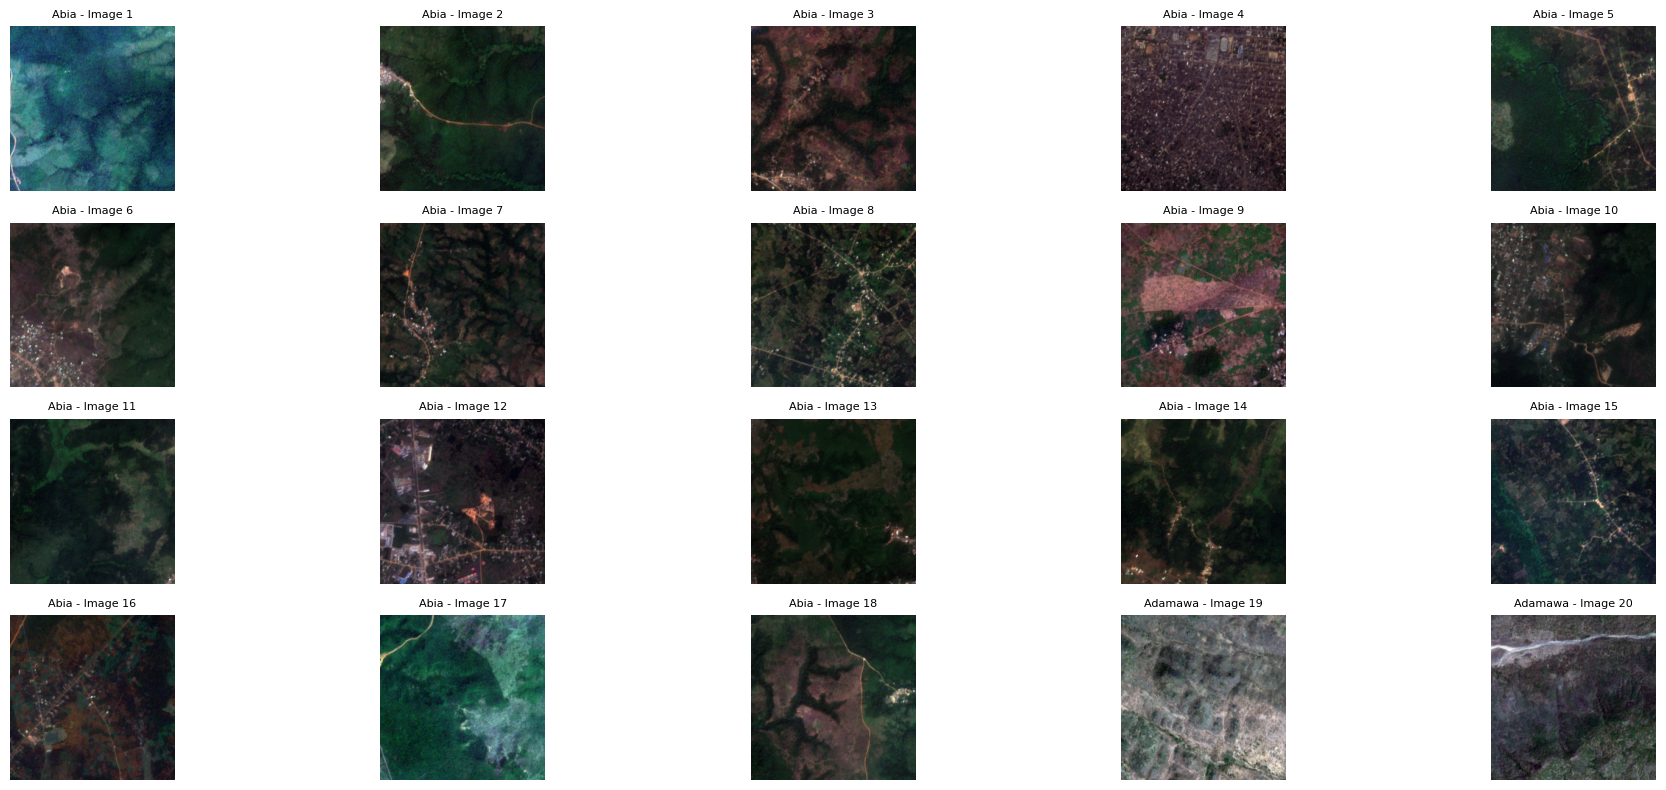

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Nehmen wir an, dass train_images eine Liste von Arrays ist, die die Bilddaten enthält.
# train_images = [...]

# Überprüfen, ob mindestens 20 Bilder vorhanden sind
assert len(train_images) >= 20, "Nicht genügend Trainingsbilder verfügbar."

# Anzahl der anzuzeigenden Bilder
num_images = 20
num_rows = 4  # Für 20 Bilder verwenden wir 4 Zeilen
num_cols = 5  # und 5 Spalten

# Erstellen der Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))

# Bilder anzeigen
for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    # Angenommen, jedes Bild hat Bänder in der ersten Dimension und ist 100x100 Pixel groß
    img = train_images[i]
    # Normalisieren und anzeigen, nehmen Sie die ersten drei Bänder für RGB
    img_norm = np.zeros((img.shape[1], img.shape[2], 3))
    for band in range(3):
        img_band = img[band, :, :]
        img_norm[:, :, band] = (img_band - img_band.min()) / (img_band.max() - img_band.min())
    
    ax.imshow(img_norm, aspect='equal')
    ax.set_title(f'{train_labels[i]} - Image {i+1}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
train_images[0].shape

(4, 224, 224)

In [12]:
import pandas as pd
import numpy as np

# Laden der MPI-Daten aus einer CSV-Datei
mpi_data = pd.read_csv('nigeria_mpi_only.csv')

# Erstellen eines Dictionaries, um Regionsnamen auf MPI-Werte abzubilden
mpi_dict = pd.Series(mpi_data.mpi.values, index=mpi_data.region).to_dict()

# Zuordnen von MPI-Werten zu Ihren Trainings- und Testetiketten
train_mpi_scores = np.array([mpi_dict[region] for region in train_labels])
test_mpi_scores = np.array([mpi_dict[region] for region in test_labels])


In [13]:
# Konvertieren der Liste in ein NumPy-Array und Transponieren der Achsen
train_images_np = np.array(train_images).transpose(0, 2, 3, 1)
test_images_np = np.array(test_images).transpose(0, 2, 3, 1)

# Entfernen des Infrarotkanals, um nur die ersten drei RGB-Kanäle zu behalten
train_images_np = train_images_np[:, :, :, :3]
test_images_np = test_images_np[:, :, :, :3]


In [14]:
train_images_np.shape

(666, 224, 224, 3)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)

datagen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    zoom_range=0.2,  # Zufälliges Zoomen innerhalb dieses Bereichs
    shear_range=0.2,  # Scherintensität
    brightness_range=[0.5, 1.5],  # Helligkeitsbereich für Anpassungen
    fill_mode='nearest'
)


# Angenommen, `train_images_rgb` ist Ihr vorbereitetes Trainingsdatenset
# Sie müssen die Daten möglicherweise in die Form (Anzahl, Höhe, Breite, Kanäle) bringen

# Die Augmentation durchführen
augmented_images = []
for i in range(len(train_images_np)):
    img = np.expand_dims(train_images_np[i], axis=0)  # Bild in ein Batch umwandeln
    it = datagen.flow(img, batch_size=1)
    for _ in range(50):  # # 60 fuer val test split, 50 fuer nur test
        aug_img = next(it)
        augmented_images.append(aug_img[0])

# Jetzt `augmented_images` als erweiterten Trainingsdatensatz verwenden


In [16]:
# Angenommen, jedes Originalbild wurde in vier augmentierte Bilder umgewandelt
augmented_mpi_scores = np.repeat(train_mpi_scores, 50) # 60 fuer val test split, 50 fuer nur test

# Konvertieren Sie augmented_images in ein NumPy-Array für das Training
augmented_images_np = np.array(augmented_images)


In [17]:
import torch

if torch.cuda.is_available():
    print("Eine GPU ist verfügbar.")
else:
    print("Keine GPU verfügbar.")


Eine GPU ist verfügbar.


In [18]:
# Vor dem Konvertieren in Tensoren und Übertragen auf das Gerät
augmented_images_np = np.transpose(augmented_images_np, (0, 3, 1, 2))

In [19]:
augmented_images_np.shape

(33300, 3, 224, 224)

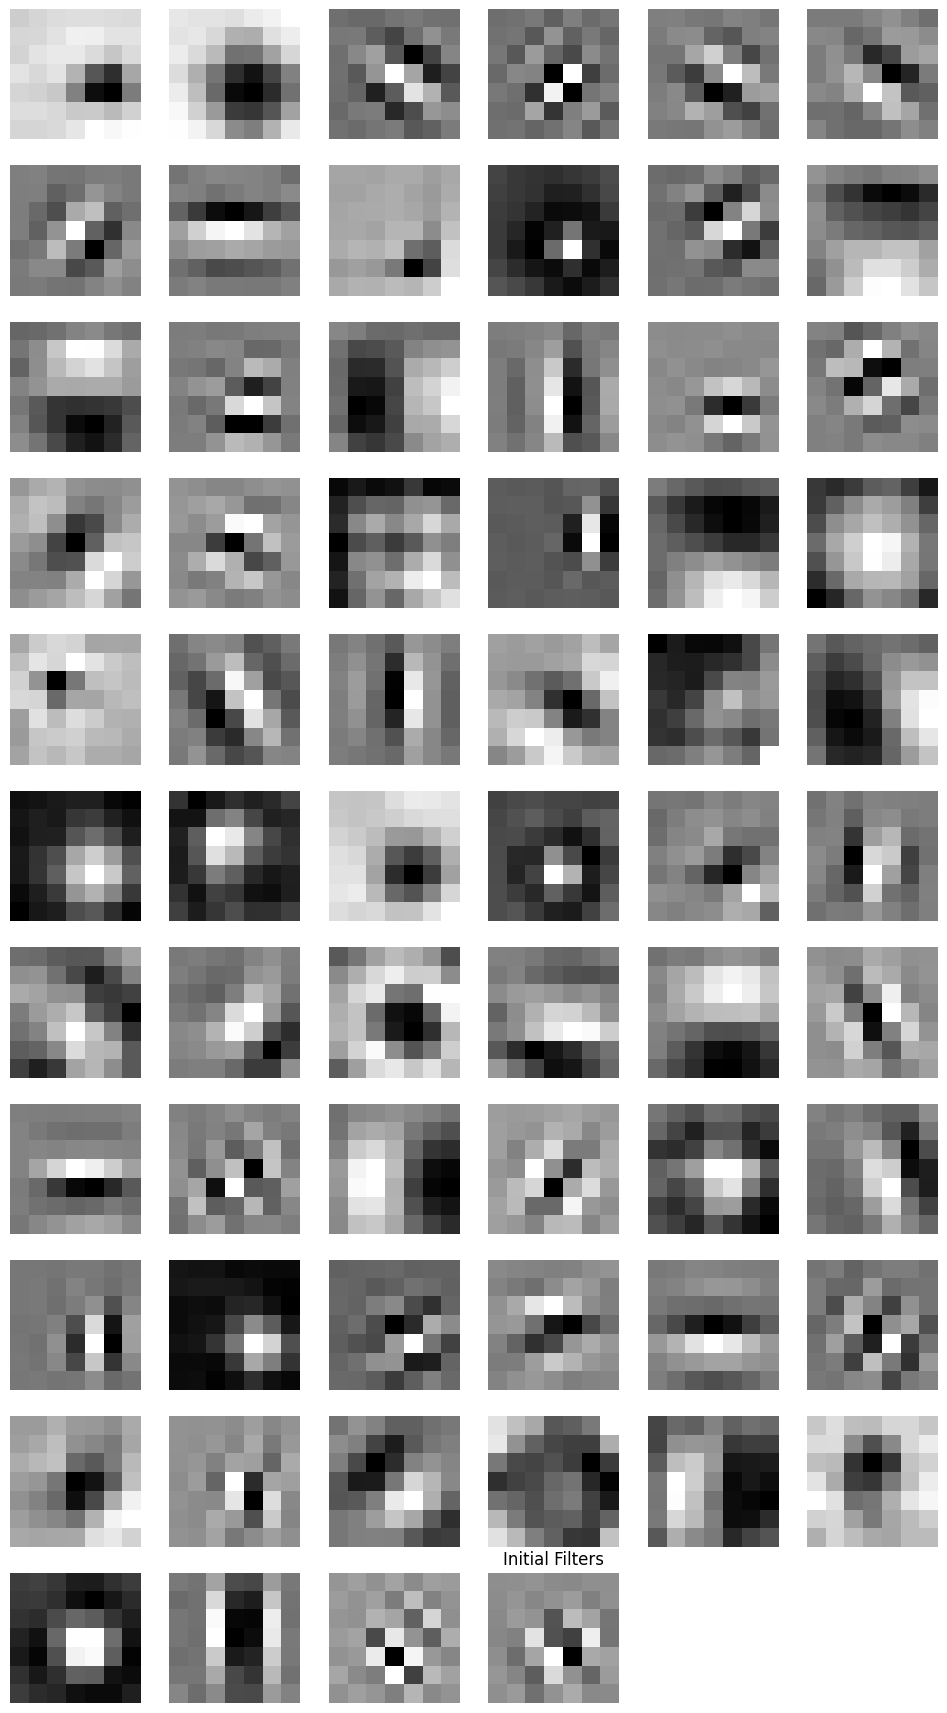

Epoch 1:   0%|          | 0/833 [00:00<?, ?it/s]

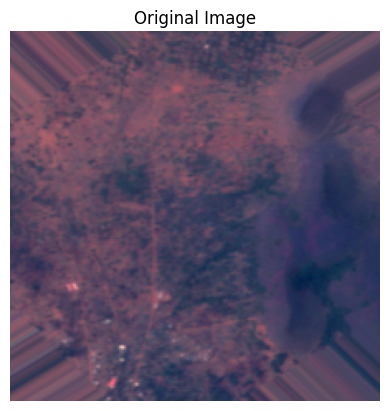

Actual Label: 0.05400000140070915


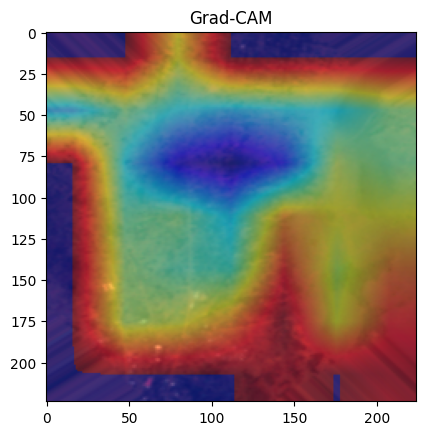

Epoch 1:   0%|          | 1/833 [00:01<26:53,  1.94s/it]

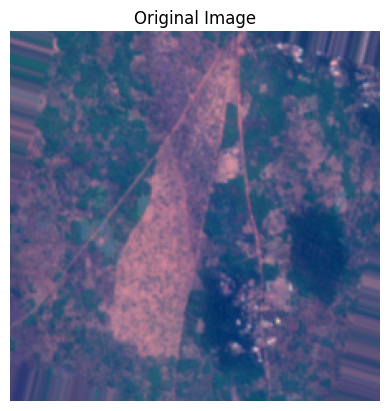

Actual Label: 0.02800000086426735


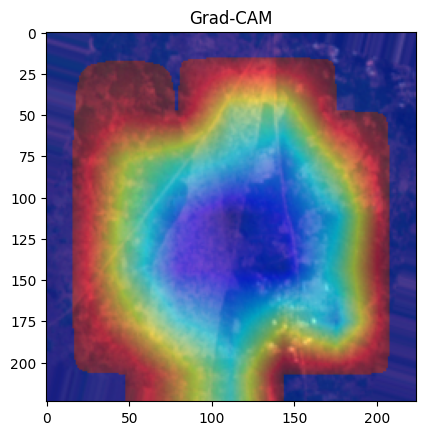

Epoch 1:   0%|          | 2/833 [00:02<13:37,  1.02it/s]

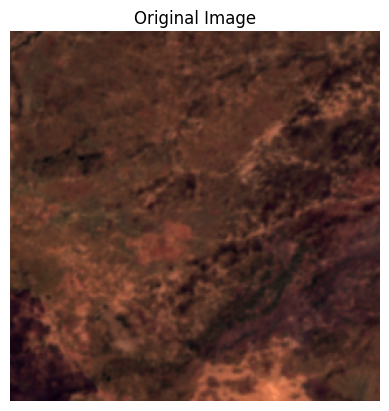

Actual Label: 0.25200000405311584


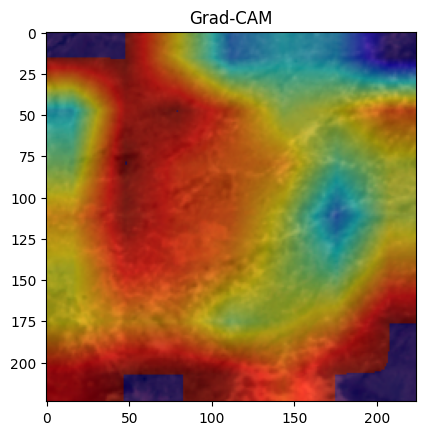

Epoch 1:   0%|          | 3/833 [00:02<09:13,  1.50it/s]

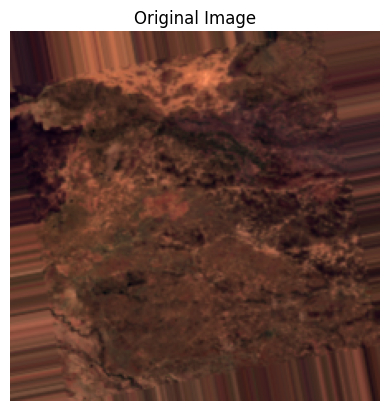

Actual Label: 0.25200000405311584


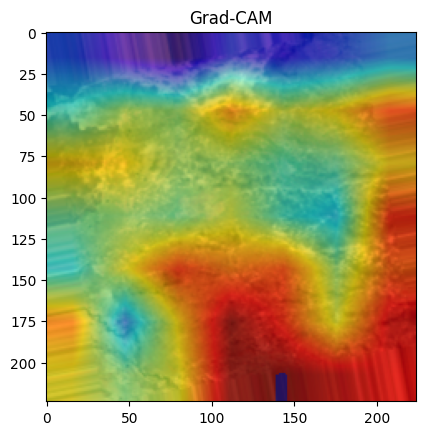

Epoch 1:   0%|          | 4/833 [00:03<09:08,  1.51it/s]

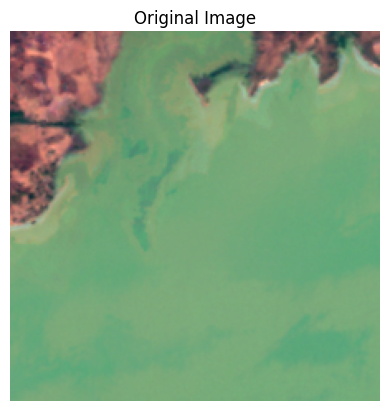

Actual Label: 0.3140000104904175


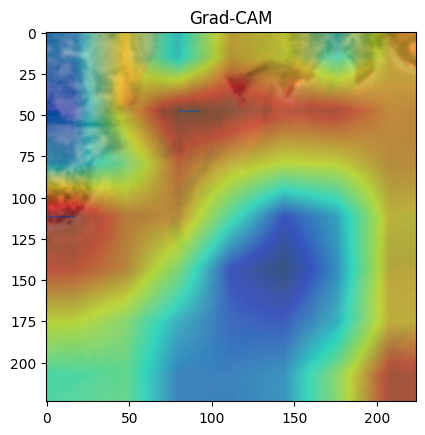

Epoch 1: 100%|██████████| 833/833 [00:32<00:00, 25.90it/s]


Epoch 1: Train Loss: 0.0053, Val Loss: 0.0042


Epoch 2: 100%|██████████| 833/833 [00:30<00:00, 27.47it/s]


Epoch 2: Train Loss: 0.0042, Val Loss: 0.0041


Epoch 3: 100%|██████████| 833/833 [00:29<00:00, 27.79it/s]


Epoch 3: Train Loss: 0.0039, Val Loss: 0.0037


Epoch 4: 100%|██████████| 833/833 [00:31<00:00, 26.46it/s]


Epoch 4: Train Loss: 0.0038, Val Loss: 0.0038


Epoch 5: 100%|██████████| 833/833 [00:32<00:00, 25.66it/s]


Epoch 5: Train Loss: 0.0037, Val Loss: 0.0038


Epoch 6: 100%|██████████| 833/833 [00:31<00:00, 26.40it/s]


Epoch 6: Train Loss: 0.0036, Val Loss: 0.0037


Epoch 7: 100%|██████████| 833/833 [00:32<00:00, 25.61it/s]


Epoch 7: Train Loss: 0.0035, Val Loss: 0.0036


Epoch 8: 100%|██████████| 833/833 [00:33<00:00, 24.94it/s]


Epoch 8: Train Loss: 0.0034, Val Loss: 0.0034


Epoch 9: 100%|██████████| 833/833 [00:31<00:00, 26.45it/s]


Epoch 9: Train Loss: 0.0034, Val Loss: 0.0038


Epoch 10: 100%|██████████| 833/833 [00:31<00:00, 26.82it/s]


Epoch 10: Train Loss: 0.0033, Val Loss: 0.0033


Epoch 11: 100%|██████████| 833/833 [00:30<00:00, 27.14it/s]


: 

In [20]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models.resnet import ResNet101_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

# Visualization Helper Functions
def plot_kernels(tensor, num_cols=6, title="Filters"):
    if not tensor.ndim == 4:
        raise Exception("Assumes a 4D tensor")
    num_kernels = tensor.shape[0]
    num_rows = (num_kernels + num_cols - 1) // num_cols
    fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)
        ax1.imshow(tensor[i][0].detach().cpu(), cmap='gray')
        ax1.axis('off')
    plt.title(title)
    plt.show()

def visualize_training(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def visualize_input_image(image_tensor):
    """ Helper function to visualize the actual input image """
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-101 Model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer for regression
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

# Move the model to GPU
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Data transformation pipeline for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Assuming train_images_cuda and train_labels_cuda are your loaded data
train_images_cuda = torch.tensor(augmented_images_np, dtype=torch.float).to(device)
train_labels_cuda = torch.tensor(augmented_mpi_scores, dtype=torch.float).unsqueeze(1).to(device)

# Total dataset loading
total_dataset = TensorDataset(train_images_cuda, train_labels_cuda)

# Splitting the dataset into training and validation
train_size = int(0.8 * len(total_dataset))
val_size = len(total_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(total_dataset, [train_size, val_size])

# Convert datasets to DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Optionally visualize filters before training
plot_kernels(next(model.children()).weight, title="Initial Filters")

# Initialize lists to store loss values for visualization
train_losses = []
val_losses = []

# Setup Grad-CAM
target_layer = model.layer4[-1]  # The last layer of layer4
gradcam = GradCAM(model=model, target_layers=[target_layer])

# Training loop with Grad-CAM and filter visualization
model.train()
for epoch in range(50):
    
    train_loss = 0
    visualization_count = 0  # Zählvariable für die Visualisierung
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Visualisierung nur für die ersten 5 Einträge jeder Epoche
        if epoch % 25 == 0 and visualization_count < 5:
            model.eval()

            # Visualisieren Sie nur das aktuelle Bild und Label
            visualize_input_image(inputs[0])  # Visualisieren Sie das Originalbild
            print("Actual Label:", labels[0].item())  # Drucken Sie das aktuelle Label

            # Grad-CAM-Visualisierung für das erste Bild
            cam_input = inputs[:1].clone().requires_grad_(True)  # Verwenden Sie nur das erste Bild
            cam = gradcam(input_tensor=cam_input)
            cam_image = cam[0, :]  # Nehmen Sie das CAM für das erste Bild
            cam_image = np.uint8(255 * cam_image)
            input_image = cam_input[0].permute(1, 2, 0).cpu().detach().numpy()
            input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Normalisieren
            visualization = show_cam_on_image(input_image, cam_image, use_rgb=True)
            plt.imshow(visualization)
            plt.title("Grad-CAM")
            plt.show()

            visualization_count += 1  # Zähler erhöhen

    # Validation phase and logging as before
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs.to(device))
            val_loss += criterion(val_outputs, val_labels.to(device)).item()

    # Calculate and store average loss
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# After all epochs, visualize training and validation losses
visualize_training(train_losses, val_losses)

In [ ]:
test_images_np = np.transpose(test_images_np, (0, 3, 1, 2))

In [ ]:
print(test_images_np.shape, augmented_images_np.shape)

In [ ]:
model.eval()
with torch.no_grad():
    test_images_tensor = torch.tensor(test_images_np).float().to(device)
    predicted_mpi_scores_tensor = model(test_images_tensor)
    predicted_mpi_scores = predicted_mpi_scores_tensor.view(-1).cpu().numpy()

# Vorhersagen in ein flaches Array konvertieren, falls sie nicht bereits flach sind
predicted_mpi_scores = predicted_mpi_scores.flatten()

# Annahme: Jede Region hat eine gleiche Anzahl von Testbildern, die in der Reihenfolge in `test_labels` enthalten sind
unique_test_regions, test_region_indices = np.unique(test_labels, return_inverse=True)
num_images_per_region = len(test_images) // len(unique_test_regions)
agg_predicted_scores = np.array([predicted_mpi_scores[test_region_indices == i].mean() for i in range(len(unique_test_regions))])

# Bereiten Sie die tatsächlichen MPI-Werte für die Testregionen vor
actual_mpi_scores = np.array([mpi_dict[region] for region in unique_test_regions])

# Leistungsmetriken berechnen
mse = np.mean((agg_predicted_scores - actual_mpi_scores)**2)
mae = np.mean(np.abs(agg_predicted_scores - actual_mpi_scores))
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_mpi_scores, agg_predicted_scores))

# Calculate R-squared (R²)
r2 = r2_score(actual_mpi_scores, agg_predicted_scores)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


In [ ]:
import matplotlib.pyplot as plt

# Erstelle ein GeoDataFrame für die Geometrien jeder Region
regions_shapes = gpd.GeoDataFrame(columns=['geometry', 'Region'])
for _, row in admin_shapes.iterrows():
    temp_gdf = gpd.GeoDataFrame({'geometry': [row['geometry']], 'Region': [row['ADM1_EN']]})
    regions_shapes = pd.concat([regions_shapes, temp_gdf], ignore_index=True)

# Verknüpfe MPI-Daten
regions_shapes = regions_shapes.merge(mpi_data, left_on='Region', right_on='region', how='left')


# Erstelle ein DataFrame für die vorhergesagten Werte
predicted_df = pd.DataFrame({
    'Region': unique_test_regions,
    'Predicted_MPI': agg_predicted_scores
})

# Verknüpfe die vorhergesagten Werte mit den geografischen Daten
regions_shapes = regions_shapes.merge(predicted_df, on='Region', how='left')

# Bestimme die Skalierung für die Farbkarte basierend auf dem kombinierten Bereich der tatsächlichen und vorhergesagten Werte
vmin = min(regions_shapes['mpi'].min(), regions_shapes['Predicted_MPI'].min())
vmax = max(regions_shapes['mpi'].max(), regions_shapes['Predicted_MPI'].max())

# Definiere die Figur und die Achsen
fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Zwei Subplots nebeneinander

# Plot der tatsächlichen MPI-Werte
regions_shapes.plot(ax=axes[0], column='mpi', cmap='OrRd', vmin=vmin, vmax=vmax)
axes[0].set_title('Actual MPI Scores')
axes[0].set_axis_off()

# Plot der vorhergesagten MPI-Werte
regions_shapes.plot(ax=axes[1], column='Predicted_MPI', cmap='OrRd', vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted MPI Scores')
axes[1].set_axis_off()

# Add a colorbar to the figure instead of the individual plots
fig.colorbar(plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.07, pad=0.07, label='MPI Score')

plt.show()
